# Demo RNA Multi-Perceptrón Backpropagation para identificar clases
Adaptado de https://www.tensorflow.org/tutorials/estimator/premade

1) Cargar librerías:

In [ ]:
#@title Librerías a usar
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import os
import csv

print("Librerías cargadas")

Librerías cargadas


2) Cargar los datos:

In [ ]:
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [ ]:
## selección de los parámetros 

def cargarNombreClases(path, archivo_datos, atributo_clase, nombre_clases):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return atributo_clase, nombre_clases

#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Nombre del atributo clase / objetivo:
atributo_clase = '-' #@param {type:"string"}
#@markdown ### Descripción de los valores del atributo clase / objetivo:  (nota: siempre debe comienzar en 0, por lo que si no tiene valor 0, agregar "na")
nombre_clases = '-' #@param {type:"string"}
#@markdown ### Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   70#@param {type:"integer"}

## aplicación de los parámetros elegidos

if atributo_clase == '' or  atributo_clase == '-':
  # trata de obtener la configuración del archivo asociado
  atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos, atributo_clase, nombre_clases)


# define nombre atributo de CLASE para ejemplo IRIS
ClassAttributeName = atributo_clase

# define valores de clases para ejemplo IRIS
CLASES = [ ]
for val in nombre_clases.split(','):
  CLASES.append( val )

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

print("Configuración definida de ", archivo_datos)
print("Atributo clase: ", ClassAttributeName, ": ", CLASES)


> Definición de los valores discretos para la clase cargada de IRIS_nombreClases.txt.

Configuración definida de  IRIS.csv
Atributo clase:  Clase :  ['na', 'Setosa', 'Versicolor', 'Virginica']


In [ ]:
#@title Cargar datos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos)
print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())


# genera los datos solo con la clase para entrenar y probar
Y = np.array(df.pop(ClassAttributeName))
X = np.array(df)


> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max       7.900000     4.400000     6.9

In [ ]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = True #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(X[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler": 
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler": 
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler": 
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler": 
    scaler = preprocessing.RobustScaler()
  
  # normaliza los datos de entrada
  X = scaler.fit_transform(X)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(X[:10])

10 primeros datos de Entrada antes de normalizar: 
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]


10 primeros datos de Entrada después de normalizar: 
[[-0.90068117  1.03205722 -1.3412724  -1.31297673]
 [-1.14301691 -0.1249576  -1.3412724  -1.31297673]
 [-1.38535265  0.33784833 -1.39813811 -1.31297673]
 [-1.50652052  0.10644536 -1.2844067  -1.31297673]
 [-1.02184904  1.26346019 -1.3412724  -1.31297673]
 [-0.53717756  1.95766909 -1.17067529 -1.05003079]
 [-1.50652052  0.80065426 -1.3412724  -1.18150376]
 [-1.02184904  0.80065426 -1.2844067  -1.31297673]
 [-1.74885626 -0.35636057 -1.3412724  -1.31297673]
 [-1.14301691  0.10644536 -1.2844067  -1.4444497 ]]


In [ ]:
#@title Preparar datos

# separa al azar usando muestreo estratificado con proporción indicada
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y)

# genera salida codificada para softMax
y_trainEnc =  np_utils.to_categorical(y_train)
y_testEnc =  np_utils.to_categorical(y_test)

# muestra resultados
print("> Para Ambos: ")
print(" - dictMapeo: ", CLASES)

print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
for i in range(len(CLASES)):
  cant = 0
  for y in y_train:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
for i in range(len(CLASES)):
  cant = 0
  for y in y_test:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)


> Para Ambos: 
 - dictMapeo:  ['na', 'Setosa', 'Versicolor', 'Virginica']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (104, 4)
 - y_train (cant):  104
     na [ 0 ]: 0
     Setosa [ 1 ]: 35
     Versicolor [ 2 ]: 34
     Virginica [ 3 ]: 35

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (46, 4)
 - y_test (cant):  46
     na [ 0 ]: 0
     Setosa [ 1 ]: 15
     Versicolor [ 2 ]: 16
     Virginica [ 3 ]: 15


3) Establecer el modelo para la RNA

In [ ]:
rna_cant_neuronas_capas_ocultas = 'BN, 240, 60, D, 12' #@param {type:"string"}
#@markdown   - Nota: 'D' indica capa Drop-Out y 'BN' indica capa Batch-Normalization
rna_tipo_capa_salida = 'lineal-Numero' #@param ["lineal-Numero", "softmax-MultiClase"]
rna_cant_epocas_entrenamiento =  100#@param {type:"integer"}

# define tamaño de datos de entrada 
num_inputs = x_train.shape[1]

# cantidad de neuronas ocultas 
#hidden_layers = [ num_inputs*3//4, num_inputs//2 ] 
hidden_layers = []
for val in rna_cant_neuronas_capas_ocultas.split(', '):
  if val == "D":
    hidden_layers.append( "DropOut" )  
  elif val == "BN":
    hidden_layers.append( "BatchNormalization" )  
  elif val.isnumeric():
    hidden_layers.append( val )
  else:
    print("Capa ", val, "descartada!")

# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
tipo_output_softMax = (rna_tipo_capa_salida[:7] == 'softmax')

# cantidad de épocas del entrenamiento
cantEpocas = (100 if rna_cant_epocas_entrenamiento<1 else rna_cant_epocas_entrenamiento)

print("Configuración de RNA MLP Backpropagation definida: \n[", num_inputs, hidden_layers, ("Softmax" if tipo_output_softMax else "Dense[1] ")," ] ")

Configuración de RNA MLP Backpropagation definida: 
[ 4 ['BatchNormalization', '240', '60', 'DropOut', '12'] Dense[1]   ] 


Modelo creado con  7  capas:
Model: "RNA"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 4)]               0         
                                                                 
 bn1 (BatchNormalization)    (None, 4)                 16        
                                                                 
 hidd_2 (Dense)              (None, 240)               1200      
                                                                 
 hidd_3 (Dense)              (None, 60)                14460     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 hidd_4 (Dense)              (None, 12)                732       
                                                                 
 output (Dense)              (None

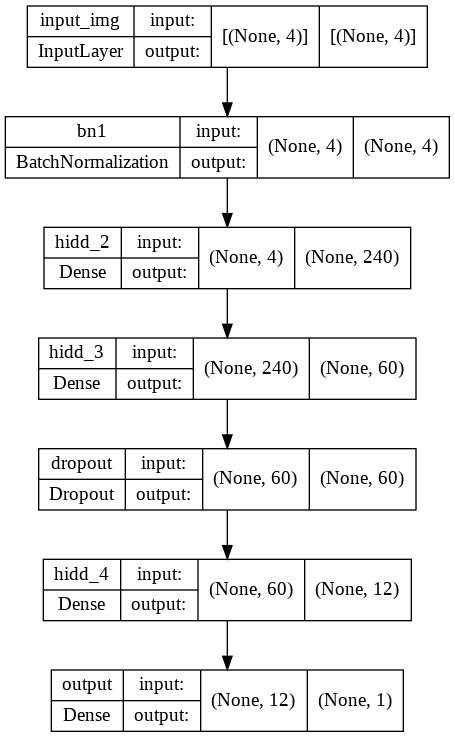

In [ ]:
#@title Establecer modelo

opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.05 #@param {type: "number"}

# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente
input_img_Lay = Input(shape=(num_inputs,), name='input') # capa de entrada
eachLay = input_img_Lay
auxName = 'hidd_'
auxId = 1 
for val_hid in hidden_layers:  

  if val_hid == "DropOut":
    eachLay = Dropout(0.2)(eachLay)
  elif val_hid == "BatchNormalization":
    auxlayerName = "bn"+str(auxId)
    auxId = auxId + 1
    eachLay = BatchNormalization(name=auxlayerName)(eachLay)
  elif val_hid.isnumeric():
    # agrega la capa oculta
    auxlayerName = auxName+str(auxId)
    auxId = auxId + 1
    eachLay = Dense(int(val_hid), name=auxlayerName)(eachLay) # capas ocultas

# agrega capa de salida
if tipo_output_softMax:
    # se genera una capa softmax
    output_img_Lay = Dense(units = len(CLASES), activation='softmax', name='output')(eachLay) # capa de salida
else:
    # se genera una capa lineal con una salida numérica
    output_img_Lay = Dense(1, activation=None, name='output')(eachLay) # capa de salida


if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam()

# genera el modelo RNA MLP Backpropagation
model = Model(input_img_Lay, output_img_Lay, name='RNA')
if tipo_output_softMax:
    # utiliza un loss de multiple clases
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
else:
    # utiliza un loss de valor numérico
    model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)


4) Entrenar el modelo de la RNA:

In [ ]:
#@title Entrenar

activar_corte_por_estabilidad_error_val = False #@param {type:"boolean"}

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                       (y_trainEnc if tipo_output_softMax else y_train), 
                                       test_size=0.1)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

if activar_corte_por_estabilidad_error_val:
  # se agrega un callBack para que corte 
  # si el error de validación no sigue bajando
  # y devuelva los mejores pesos obtenidos
  early_stopping_monitor = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0.01,
      patience=20,
      verbose=0,
      mode='min',
      baseline=None,
      restore_best_weights=True
  )
  callbacksEntr = [early_stopping_monitor]
else:
  early_stopping_monitor = None
  callbacksEntr = []

# lleva a cabo el entrenamiento
history = model.fit(x_t, y_t,
          epochs = cantEpocas, 
          validation_data=(x_v, y_v,),
          callbacks=callbacksEntr ) 

print("\n>Entrenamiento Finalizado.")



> De los  104 ejemplos de entrenamiento: 
            se usan  93 ejemplos para entrenar 
            y  11 ejemplos para validar.


>Comienza el Entrenamiento:
Epoch 1/100
3/3 [==============================] - 1s 104ms/step - loss: 172.7955 - accuracy: 0.2151 - val_loss: 150.7200 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 80.9508 - accuracy: 0.0968 - val_loss: 19.5109 - val_accuracy: 0.2727
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 13.8042 - accuracy: 0.3441 - val_loss: 6.4031 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 0s 15ms/step - loss: 20.0927 - accuracy: 0.0108 - val_loss: 1.8042 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 0s 16ms/step - loss: 8.5245 - accuracy: 0.2473 - val_loss: 20.3804 - val_accuracy: 0.2727
Epoch 6/100
3/3 [==============================] - 0s 16ms/step - loss: 8.6897 - accuracy: 0.3441 - val_loss: 0.5156

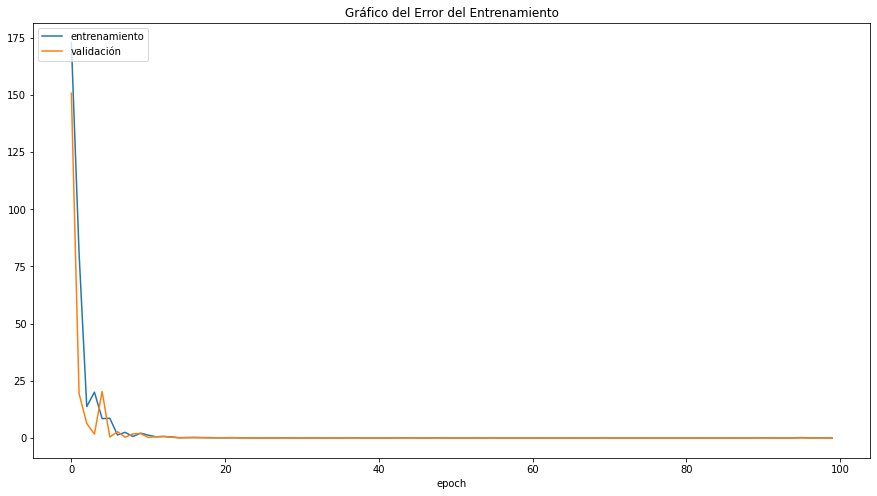

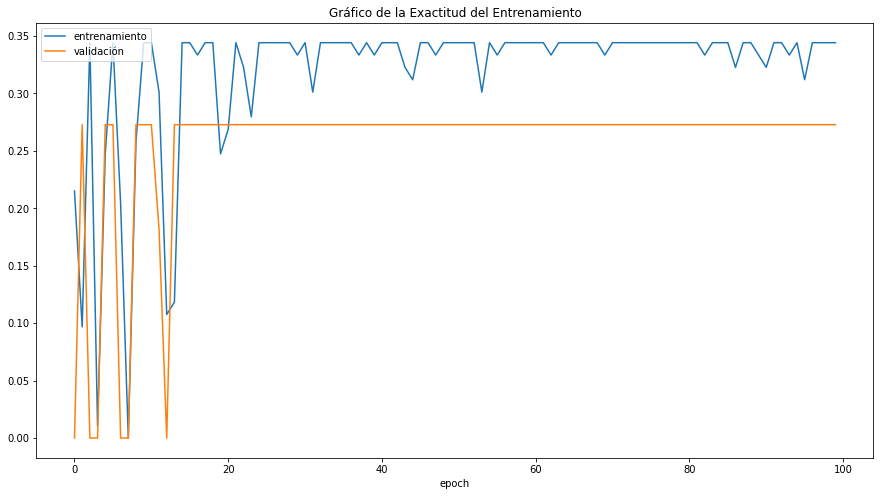

In [ ]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8)) 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Gráfico de la Exactitud del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        35
  Versicolor       0.87      1.00      0.93        34
   Virginica       1.00      0.86      0.92        35

    accuracy                           0.95       104
   macro avg       0.96      0.95      0.95       104
weighted avg       0.96      0.95      0.95       104


Matriz de Confusión ( real / modelo ): 
              m:na  m:Setosa  m:Versicolor  m:Virginica
r:na             0         0             0            0
r:Setosa         0        35             0            0
r:Versicolor     0         0            34            0
r:Virginica      0         0             5           30




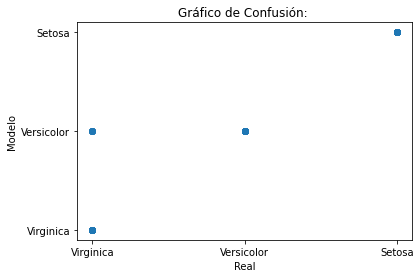

In [ ]:
#@title Probar red entrenada con datos de entrenamiento

mostrar_detalle_entrenamiento = False #@param {type:"boolean"}

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, clases_map, mostrarDetalle=False):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ] 

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]       
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA"
        else:      
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = 'Real: ' + clReal + ' / Modelo(RNA): ' 
        strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'   
        strTitulo = strTitulo + ": " + ("ok" if (clPred==clReal) else "error!")

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    print(cmtx)
    print("\n")

    # gráfico de comparación
    plt.title('Gráfico de Confusión: ')
    plt.xlabel('Real')
    plt.ylabel('Modelo')
    plt.scatter(classReal, classPreds)

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, y_train, CLASES, mostrar_detalle_entrenamiento)


6) Evaluar el modelo de la RNA entrenado con los datos de prueba:

2/2 [==============================] - 0s 9ms/step - loss: 0.0805 - accuracy: 0.3261

>Evaluación del Modelo: 
    - Error:  0.08054371178150177
    - Exactitud:  32.608696818351746




*** Resultados con datos de Prueba: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        15
  Versicolor       0.76      1.00      0.86        16
   Virginica       1.00      0.67      0.80        15

    accuracy                           0.89        46
   macro avg       0.92      0.89      0.89        46
weighted avg       0.92      0.89      0.89        46


Matriz de Confusión ( real / modelo ): 
              m:na  m:Setosa  m:Versicolor  m:Virginica
r:na             0         0             0            0
r:Setosa         0        15             0            0
r:Versicolor     0         0            16            0
r:Virginica      0         0             5           10




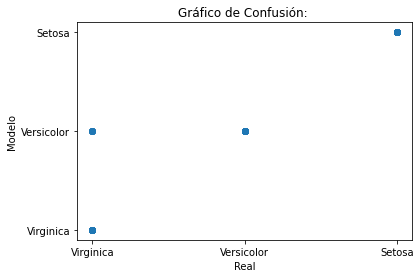

In [ ]:
#@title Probar red entrenada con datos de prueba
mostrar_detalle_prueba = False #@param {type:"boolean"}

 
 # evalua al modelo entrenado
resEval = model.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test),)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
probarModelo(x_test, y_test, CLASES, mostrar_detalle_prueba)

In [ ]:
#@title Inspeccionar influencia de los Atributos de Entrada
# fuente: https://scikit-learn.org/stable/modules/permutation_importance.html

from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

# define la función para calculo del error
# contando la cantidad de diferencias 
# entre clase real y predecida
def calc_error(realClasses, predClasses):
    res = 0
    for i in range(len(realClasses)):
      # determina la clase predecida
      if tipo_output_softMax:
          ## determina clase predecida de acuerdo a la que tiene mayor valor
          idclPred = int( np.argmax(predClasses[i], axis=0) )
          idclPredRnd = idclPred
          idReal = int( np.argmax(realClasses[i], axis=0) )
      else:
          ## determina clase predecida de acuerdo al umbral de clasificación
          idclPred = predClasses[i][0]       
          idclPredRnd = int(idclPred)
          if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(CLASES):
                  idclPredRnd = idclPredRnd + 1
          idReal = int(realClasses[i])
      res = res + abs(idReal-idclPredRnd)
    return res
errorScorer = make_scorer(calc_error, greater_is_better=False)

def realizarInspeccion(tipoDatos, xScoring, yScoring):
  print("")
  # Genera el scoring usando permutaciones 
  # para realizar el cálculo del scoring
  scoring = {'R2 score':'r2', 
             'Error de Clase':errorScorer}
  r_multi  = permutation_importance(model, xScoring, yScoring,
                              n_repeats=30,
                              random_state=0,
                              scoring=scoring)

  # muesta las métricas
  print("> Cálculo de influencia con datos de " + tipoDatos + ":")
  for metric in r_multi:
    print("- Métrica "+metric+":")
    r = r_multi[metric]
    i = 0
    for imp in r.importances:
        print(f"\tAtributo {i:<2} [ {df.columns[i]} ]:  "
              f"{np.mean(imp):.3f} ± {np.std(imp):.3f}"
              f" [ {np.min(imp):.3f}; {np.max(imp):.3f} ]"
              )
        i = i + 1
  return

# Ejecuta con ambos sets de datos
realizarInspeccion(tipoDatos="Entrenamiento",  
                  xScoring = x_train,
                  yScoring = (y_trainEnc if tipo_output_softMax else y_train))

realizarInspeccion(tipoDatos="Prueba",  
                  xScoring = x_test,
                  yScoring = (y_testEnc if tipo_output_softMax else y_test))




> Cálculo de influencia con datos de Entrenamiento:
- Métrica R2 score:
	Atributo 0  [ LargoSepalo ]:  0.002 ± 0.001 [ 0.000; 0.005 ]
	Atributo 1  [ AnchoSepalo ]:  0.003 ± 0.002 [ -0.000; 0.009 ]
	Atributo 2  [ LargoPetalo ]:  0.254 ± 0.033 [ 0.189; 0.320 ]
	Atributo 3  [ AnchoPetalo ]:  0.756 ± 0.087 [ 0.595; 0.913 ]
- Métrica Error de Clase:
	Atributo 0  [ LargoSepalo ]:  0.233 ± 0.496 [ 0.000; 2.000 ]
	Atributo 1  [ AnchoSepalo ]:  1.333 ± 0.830 [ 0.000; 3.000 ]
	Atributo 2  [ LargoPetalo ]:  24.333 ± 3.249 [ 17.000; 29.000 ]
	Atributo 3  [ AnchoPetalo ]:  62.167 ± 4.539 [ 54.000; 72.000 ]

> Cálculo de influencia con datos de Prueba:
- Métrica R2 score:
	Atributo 0  [ LargoSepalo ]:  -0.000 ± 0.002 [ -0.002; 0.003 ]
	Atributo 1  [ AnchoSepalo ]:  0.010 ± 0.004 [ 0.003; 0.019 ]
	Atributo 2  [ LargoPetalo ]:  0.279 ± 0.049 [ 0.212; 0.421 ]
	Atributo 3  [ AnchoPetalo ]:  0.734 ± 0.128 [ 0.564; 1.096 ]
- Métrica Error de Clase:
	Atributo 0  [ LargoSepalo ]:  0.000 ± 0.000 [ 0.000; 0.